# Introduction

This notebook demonstrates how to refit a MEGNet formation energy model using PyTorch Lightning with MatGL.

In [1]:
#pip install matplotlib pandas pytorch-lightning tqdm pymatgen dgl matgl

In [24]:
from __future__ import annotations

# 기본 Python 모듈 및 패키지 import
import os             # 운영 체제와 상호 작용하기 위한 모듈
import shutil         # 파일 및 디렉토리 작업을 위한 모듈
import warnings       # 경고를 관리하기 위한 모듈
import zipfile        # ZIP 아카이브를 처리하기 위한 모듈
import csv

import matplotlib.pyplot as plt     # 데이터 시각화를 위한 Matplotlib의 pyplot 모듈
import pandas as pd                 # 데이터 조작 및 분석을 위한 Pandas 라이브러리
import pytorch_lightning as pl      # PyTorch Lightning 라이브러리
import torch                        # PyTorch 딥러닝 프레임워크
from tqdm import tqdm               # 진행률 표시를 위한 라이브러리


# 외부 패키지 import
from dgl.data.utils import split_dataset            #  DGL(Distributed Graph Library) 패키지의 데이터 유틸리티 함수
from pymatgen.core import Structure                 #  pymatgen 라이브러리의 구조 클래스
from pytorch_lightning.loggers import CSVLogger     #  PyTorch Lightning의 CSV 로거 클래스


from matgl.ext.pymatgen import Structure2Graph, get_element_list     # matgl 라이브러리의 pymatgen 확장 모듈
from matgl.graph.data import MGLDataset, MGLDataLoader, collate_fn   # matgl 라이브러리의 그래프 데이터 관련 모듈
from matgl.layers import BondExpansion                               # matgl 라이브러리의 BondExpansion 클래스
from matgl.models import MEGNet                                      # matgl 라이브러리의 MEGNet 클래스
from matgl.utils.io import RemoteFile                                # matgl 라이브러리의 입출력 및 훈련 관련 유틸리티 모듈
from matgl.utils.training import ModelLightningModule                # matgl 라이브러리의 입출력 및 훈련 관련 유틸리티 모듈

# 경고를 무시하도록 설정하는 것으로, 출력을 더 깔끔하게 만듭니다.
warnings.simplefilter("ignore")

# Dataset Preparation

이제 MEGNet 형성 에너지 모델 훈련에 사용된 원본 데이터셋인 MP.2018.6.1을 figshare에서 다운로드하고 데이터를 캐시할 것입니다

In [4]:
import json


def load_dataset() -> tuple[list[Structure], list[str], list[float]]:
    """
    Load and process the dataset from a JSON file containing material properties.

    Returns:
        tuple[list[Structure], list[str], list[float]]: A tuple containing a list of structures, a list of material IDs, and a list of formation energies per atom.
    """
    # Assuming the dataset is named 'mpid_fE_structure_O.Si.json' and located in the current directory
    file_path = '/home/ljm/matgl_bandgap/Last_version/mpid_bg_structure_O_1.json'

    # Check if the file exists
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"{file_path} does not exist. Please make sure the dataset file is in the correct location.")

    # Load the dataset
    with open(file_path, 'r') as file:
        data = json.load(file)

    # Initialize lists to store structures, material IDs, and formation energies
    structures = []
    mp_ids = []
    band_gaps = []

    # Iterate over the dataset
    for mp_id, (band_gap, structure_dict) in data.items():
        # Create a Structure object from the structure dictionary
        structure = Structure.from_dict(structure_dict)

        # Append to the lists
        structures.append(structure)
        mp_ids.append(mp_id)
        band_gaps.append(band_gap)

    return structures, mp_ids, band_gaps

# Load the dataset
structures_org, mp_ids_org, band_gaps_org = load_dataset() # org를 붙임


In [5]:
# Shuffle dataset, 셔플되는 곳을 옮김.
from sklearn.utils import shuffle
rd_seed = 0
structures, mp_ids, band_gaps = shuffle(structures_org, mp_ids_org, band_gaps_org, random_state=rd_seed)

In [6]:
print(structures_org[0])
print(structures[0])

Full Formula (Li3 Fe6 O3 F15)
Reduced Formula: LiFe2OF5
abc   :   4.572379   8.673085   8.695360
angles:  60.172481  89.210123  88.646569
pbc   :       True       True       True
Sites (27)
  #  SP           a         b         c    magmom
---  ----  --------  --------  --------  --------
  0  Li    0.502537  0.336388  0.328836     0.006
  1  Li    0.002012  0.004104  0.994275     0.007
  2  Li    0.495455  0.664967  0.662199     0.006
  3  Fe    0.985523  0.356815  0.007905     4.413
  4  Fe    0.517935  0.672392  0.005782     4.425
  5  Fe    0.983713  0.657742  0.357584     4.422
  6  Fe    0.513705  0.987894  0.321971     4.418
  7  Fe    0.515847  0.300585  0.691866     4.413
  8  Fe    0.985247  0.005893  0.656002     4.43
  9  O     0.739641  0.460252  0.103245     0.423
 10  O     0.734111  0.77751   0.43597      0.422
 11  O     0.767901  0.106112  0.769519     0.418
 12  F     0.765042  0.12238   0.107007     0.11
 13  F     0.263811  0.219344  0.214906     0.098
 14  F     0

In [7]:
num_samples = len(structures)
print(num_samples)

57826


In [8]:
structures = structures
Band_g = band_gaps

In [9]:
# 데이터셋 내 원소 종류 추출
elem_list = get_element_list(structures)
# 그래프 변환기 설정
converter = Structure2Graph(element_types=elem_list, cutoff=5.0)
# convert the raw dataset into MEGNetDataset, 데이터셋 변환
mp_dataset = MGLDataset(
    structures=structures,
    labels={"Bgap": Band_g},
    converter=converter)

100%|██████████| 57826/57826 [02:40<00:00, 361.30it/s]


In [12]:
train_data, val_data, test_data = split_dataset(
    mp_dataset, # 모델에 입력으로 제공될 데이터셋
    frac_list=[0.8, 0.1, 0.1])

train_loader, val_loader, test_loader = MGLDataLoader(
    train_data=train_data,
    val_data=val_data,
    test_data=test_data,
    collate_fn=collate_fn,  # 데이터셋으로부터 미니배치를 생성하는 함수

    # 데이터로더에서 사용되는 미니배치의 크기를 나타내는 매개변수입니다.
    # 한 번에 처리되는 데이터 포인트의 수를 결정
    # 128개의 데이터 포인트를 동시에 처리하여 그래디언트를 계산하고 가중치를 업데이트
    batch_size=128,

    # 데이터로더에서 사용할 프로세스의 수를 나타내는 매개변수입니다.
    # 데이터를 로드하는 데 사용되는 병렬 처리의 정도를 결정

    num_workers=9,
)

num_tr_samples = len(train_data)
num_va_samples = len(val_data)
num_te_samples = len(test_data)
print(num_tr_samples)
print(num_va_samples)
print(num_te_samples)

print()

num_tr_batches = len(train_loader)
num_va_batches = len(val_loader)
num_te_batches = len(test_loader)
print(num_tr_batches)
print(num_va_batches)
print(num_te_batches)

46260
5782
5784

362
46
46


In [14]:
### Test Data
# References:
#   1) https://matgl.ai/matgl.graph.html
#   2) https://docs.dgl.ai/en/0.8.x/generated/dgl.dataloading.GraphDataLoader.html

# "test_data"
#   Type: matgl.graph.data.MGLDataset


#index에서 정한 숫자는 test data에서 첫번째 데이터를 의미
#
index = num_tr_samples + num_va_samples + 0
temp_structure = structures[index]
g_converter = Structure2Graph(element_types=elem_list, cutoff=5.0)
temp_g = g_converter.get_graph(temp_structure)
print(temp_structure)
print(temp_g)

print("--------------------------------------------------------------------------------")

print(test_data[0])
print(test_loader.dataset[0])

print()

Full Formula (Mg1 Mn2 Fe4 O8)
Reduced Formula: MgMn2(FeO2)4
abc   :   5.953008   7.027851   7.010750
angles:  51.029609  65.049210  64.778931
pbc   :       True       True       True
Sites (15)
  #  SP           a         b         c    magmom
---  ----  --------  --------  --------  --------
  0  Mg    0.663198  0.629547  0.625521     0.004
  1  Mn    0.129646  0.120499  0.121357     4.704
  2  Mn    0.881294  0.873464  0.870737     4.637
  3  Fe    0.543032  0.456406  0.452467     4.275
  4  Fe    0.437236  0.541762  0.051601     3.804
  5  Fe    0.069299  0.436446  0.435249     4.105
  6  Fe    0.434317  0.051378  0.550794     3.822
  7  O     0.71385   0.76414   0.767034     0.112
  8  O     0.260169  0.264143  0.714074     0.239
  9  O     0.259766  0.713873  0.261483     0.236
 10  O     0.691048  0.277376  0.283171     0.239
 11  O     0.763581  0.281256  0.70288      0.207
 12  O     0.285123  0.748986  0.746892     0.129
 13  O     0.230913  0.261081  0.263588     0.251
 14  O

# Model setup

In the next step, we setup the model and the ModelLightningModule. Here, we have initialized a MEGNet model from scratch. Alternatively, you can also load one of the pre-trained models for transfer learning, which may speed up the training.

In [15]:
# 노드 속성을 위한 임베딩 레이어를 설정
node_embed = torch.nn.Embedding(len(elem_list), 16)
# 본드 확장을 정의
bond_expansion = BondExpansion(rbf_type="Gaussian", initial=0.0, final=5.0, num_centers=100, width=0.5)

# MEGNet 모델의 아키텍처를 설정
model = MEGNet(
    dim_node_embedding=16,
    dim_edge_embedding=100,
    dim_state_embedding=2,#값 변동
    ntypes_stats = 4, #추가한 레이어 
    nblocks=3,
    hidden_layer_sizes_input=(64, 32),
    hidden_layer_sizes_conv=(64, 64, 32),
    hidden_layer_sizes_output=(32, 16),#위치 변경 레이어
    nlayers_set2set=1,
    niters_set2set=3,#값 변동
    activation_type="softplus2",
    is_classification=False,
    include_state= True,
    dropout= 0.3,#추가 
    graph_transformations= None, #추가 
    element_types= None,#추가 
    bond_expansion= None, #값변경 
    cutoff=5.0,#값 변경 
    gauss_width=0.5,
)
import torch.optim as optim
# setup the MEGNetTrainer
# lit_module = ModelLightningModule(model=model)

# Adam 옵티마이저 설정
adam_optimizer = optim.Adam(model.parameters(), lr=0.001)

# ModelLightningModule 초기화
lit_module = ModelLightningModule(model=model, optimizer=adam_optimizer, lr=0.001)

# Training



In [16]:
"""
from pytorch_lightning.callbacks import Callback

class PredStore(Callback):
    def __init__(self):
        self.predictions = []

    def on_test_batch_end(self, trainer, pl_module, outputs, *args, **kwargs):
        print(outputs)
        self.predictions.append(outputs)  # or extend
"""


# 모델을 train 모드로 설정합니다.
model.train()
logger = CSVLogger("logs", name="MEGNet_training")
trainer = pl.Trainer(max_epochs=500, accelerator="gpu", logger=logger)
#trainer = pl.Trainer(max_epochs=5, accelerator="gpu", logger=logger, callbacks=[PredStore()])
trainer.fit(model=lit_module, train_dataloaders=train_loader, val_dataloaders=val_loader)

torch.save(model.state_dict(), 'prediction_bandgap_1.pth')


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: logs/MEGNet_training
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params
--------------------------------------------
0 | model | MEGNet            | 189 K 
1 | mae   | MeanAbsoluteError | 0     
2 | rmse  | MeanSquaredError  | 0     
--------------------------------------------
189 K     Trainable params
100       Non-trainable params
189 K     Total params
0.758     Total estimated model params size (MB)


Epoch 499: 100%|██████████| 362/362 [01:19<00:00,  4.53it/s, v_num=0, val_Total_Loss=0.431, val_MAE=0.405, val_RMSE=0.647, train_Total_Loss=0.0991, train_MAE=0.234, train_RMSE=0.313]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 499: 100%|██████████| 362/362 [01:22<00:00,  4.39it/s, v_num=0, val_Total_Loss=0.431, val_MAE=0.405, val_RMSE=0.647, train_Total_Loss=0.0991, train_MAE=0.234, train_RMSE=0.313]


In [33]:
# 2024.05.13
# 모델을 평가 모드로 설정합니다.
"""
model.eval()


### Method 1: Use 'forward' function
temp_graph = test_data[0][0]
print(temp_graph)
temp_lat = test_data[0][1][0]
print(temp_lat)
temp_state_attr = test_data[0][2]
print(temp_state_attr)
temp_band_gap = test_data[0][3]

temp_graph.edata["pbc_offshift"] = torch.matmul(temp_graph.edata["pbc_offset"], temp_lat)
temp_graph.ndata["pos"] = temp_graph.ndata["frac_coords"] @ temp_lat
print(temp_graph)

pred_band_G = model.forward(temp_graph, temp_state_attr)
print(temp_band_gap)
print(pred_band_G)
"""
'''

for i in range(50):
    #model.load_state_dict(torch.load("/home/ljm/matgl_bandgap/add_optimizer/model_save_test_JK.pth"))
    test_id = num_tr_samples + num_va_samples + i
    
    #print(structures[test_id])
    pred_band_gap = model.predict_structure(structures[test_id])

    print("%d: The bandgap for %s is real: %.5f vs. pred: %.5f." % (test_id, mp_ids[test_id], band_gaps[test_id], pred_band_gap))
'''

### Method 2: Use 'predict_structure' function
#csv file save
save_path = "/home/ljm/matgl_bandgap/Last_version/logs/MEGNet_training"

csv_filename = "band_gap_results.csv"

# CSV 파일에 데이터를 기록합니다.
with open(csv_filename, mode='w', newline='') as file:
    writer = csv.writer(file)
    
    # 헤더를 작성합니다.
    writer.writerow(['Test ID', 'Material ID', 'Real Band Gap', 'Predicted Band Gap'])
    
    # 각 테스트 ID에 대한 데이터를 작성합니다.
    for i in range(5784):
        test_id = num_tr_samples + num_va_samples + i
        pred_band_gap = model.predict_structure(structures[test_id])
        
        row = f"{test_id}, {mp_ids[test_id]}, {band_gaps[test_id]:.5f}, {pred_band_gap:.4f}"
        
        # CSV 파일에 데이터를 작성합니다.
        writer.writerow(row.split(', '))

print("CSV 파일이 성공적으로 생성되었습니다:", csv_filename)

#print(structures[52043])

#pred_band_gap = model.predict_structure(structures[10])
#print(pred_band_gap)



CSV 파일이 성공적으로 생성되었습니다: band_gap_results.csv


In [ ]:
# 2024.05.11
#predictions = trainer.predict(model=lit_module, dataloaders=test_loader)
#print(predictions)

model.eval()
pred_band_G = model.forward(test_data[0][0], test_data[0][1])
print(pred_band_G)
#print(f"The predicted Band gap for this is {float(band_G):.3f} eV.")


# 왜 안되는가? 소스코드에 문제가 있는 것 같음.
# 상기 "pred_band_G = model.forward(test_data[0][0])"를 실행하면:
#   1) "src/matgl/models/_megnet.py" 파일의 "MEGNet" class의 "forward" 함수가 실행됨.
#   2) 이 함수의 165줄에서, "src/matgl/graph/compute.py" 파일의 "compute_pair_vector_and_distance" 함수가 실행됨.
#      이 함수는, 입력값 "g: dgl.DGLGraph"로부터 "g.ndata["pos"]"와 "g.edata["pbc_offshift"]"를 요구함.
#      그러나 1)에서 이 두가지 변수를 계산해주지 않고 있음.
#      1)의 바로 다음 함수인 "predict_structure" 함수는 이 두 값을 계산해주는 것을 확인할 수 있고, 학생이 이 파일 하단에서 실행을 성공하기도 하였음.

# 해결 방법:
#   1) 소스코드를 수정하여 에러를 없앤다.
#   2) "predict_structure" 함수를 사용하여 predicted band_G를 계산한다. 현재 이 방법을 사용하지 못하는 이유는 "test_data"의 "structures"를 알 수 없기 때문임 (shuffle 때문).
#      데이터 셋을 먼저 shuffle 한 후, 순서대로 8:1:1로 split하여 MEGNetDataset 데이터를 만들면, structures/band_gaps와 MEGNetDataset 사이의 인덱스가 동일하므로
#      training/validation에는 MEGNetDataset을 사용하고 predict_structure에는 structures 정보를 사용할 수 있을 것임.

# Prediction & evalustion Code

In [24]:
torch.save(model.state_dict(), 'pre_Bg_2.pth')


In [18]:
model.load_state_dict(torch.load("/home/ljm/matgl_bandgap/Last_version/prediction_bandgap_1.pth"))

# 모델을 평가 모드로 설정합니다.
model.eval()

MEGNet(
  (bond_expansion): BondExpansion(
    (rbf): GaussianExpansion()
  )
  (embedding): EmbeddingBlock(
    (activation): SoftPlus2(
      (ssp): Softplus(beta=1, threshold=20)
    )
    (layer_node_embedding): Embedding(89, 16)
  )
  (edge_encoder): MLP(100 → 64, SoftPlus2, 64 → 32, SoftPlus2)
  (node_encoder): MLP(16 → 64, SoftPlus2, 64 → 32, SoftPlus2)
  (state_encoder): MLP(2 → 64, SoftPlus2, 64 → 32, SoftPlus2)
  (blocks): ModuleList(
    (0): MEGNetBlock(
      (activation): SoftPlus2(
        (ssp): Softplus(beta=1, threshold=20)
      )
      (edge_func): Identity()
      (node_func): Identity()
      (state_func): Identity()
      (conv): MEGNetGraphConv(
        (edge_func): MLP(128 → 64, SoftPlus2, 64 → 64, SoftPlus2, 64 → 32, SoftPlus2)
        (node_func): MLP(96 → 64, SoftPlus2, 64 → 64, SoftPlus2, 64 → 32, SoftPlus2)
        (state_func): MLP(96 → 64, SoftPlus2, 64 → 64, SoftPlus2, 64 → 32, SoftPlus2)
      )
      (dropout): Dropout(p=0.3, inplace=False)
    )
    

In [19]:
from __future__ import annotations

import warnings

import torch
from pymatgen.core import Lattice, Structure

import matgl

# To suppress warnings for clearer output
warnings.simplefilter("ignore")

In [20]:
struct = Structure.from_spacegroup("P2_13", Lattice.cubic(5.96), ["C", "O"], [[0.959164,	0.959164,	0.959164], [0.069818,	0.069818,	0.069818]])
print(struct)

Full Formula (C4 O4)
Reduced Formula: CO
abc   :   5.960000   5.960000   5.960000
angles:  90.000000  90.000000  90.000000
pbc   :       True       True       True
Sites (8)
  #  SP           a         b         c
---  ----  --------  --------  --------
  0  C     0.540836  0.040836  0.459164
  1  C     0.040836  0.459164  0.540836
  2  C     0.959164  0.959164  0.959164
  3  C     0.459164  0.540836  0.040836
  4  O     0.430182  0.930182  0.569818
  5  O     0.930182  0.569818  0.430182
  6  O     0.069818  0.069818  0.069818
  7  O     0.569818  0.430182  0.930182


In [32]:
band_G = model.predict_structure(struct)
print(f"The predicted Band gap for CO is {float(band_G):.3f} eV.")

The predicted Band gap for CO is 5.865 eV.


Mean Absolute Error (MAE): 1.2541139004149378


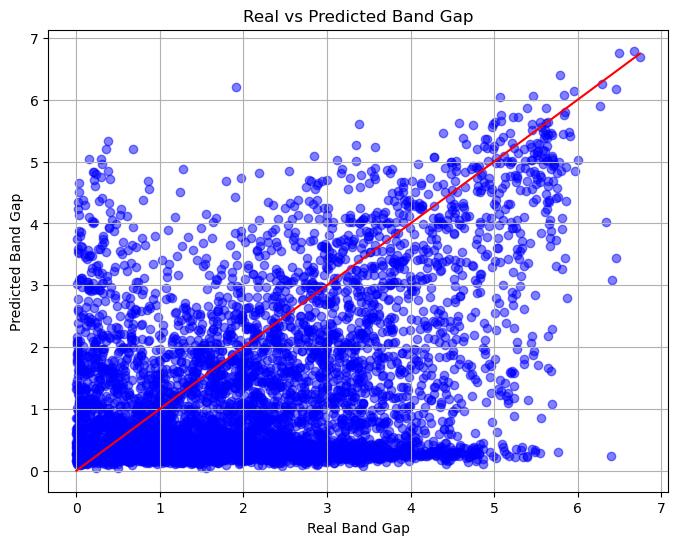

In [37]:
import pandas as pd
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# CSV 파일 읽기
data = pd.read_csv('/home/ljm/matgl_bandgap/Last_version/band_gap_results.csv')

# 실제값과 예측값 가져오기
real_values = data['Real Band Gap']
predicted_values = data['Predicted Band Gap']

# MAE 계산
mae = mean_absolute_error(real_values, predicted_values)
print("Mean Absolute Error (MAE):", mae)

# 차트 그리기
plt.figure(figsize=(8, 6))
plt.scatter(real_values, predicted_values, color='blue', alpha=0.5)
plt.plot([min(real_values), max(real_values)], [min(real_values), max(real_values)], color='red')
plt.title('Real vs Predicted Band Gap')
plt.xlabel('Real Band Gap')
plt.ylabel('Predicted Band Gap')
plt.grid(True)
plt.show()



# 초기화 코드 

다만 오류가 안나는 것을 방지하기 위해 돌리는 것을 추천

In [ ]:
# This code just performs cleanup for this notebook.
'''
for fn in ("dgl_graph.bin", "lattice.pt", "dgl_line_graph.bin", "state_attr.pt", "labels.json"):
    try:
        os.remove(fn)
    except FileNotFoundError:
        pass

shutil.rmtree("logs")
'''